In [186]:
import jax 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np 

from jax import vmap, lax, jit 
from jax.scipy.stats import norm, rankdata
from jax.scipy.special import digamma
from jax.scipy.special import gamma
from jax.scipy.linalg import cholesky
from functools import partial
from typing import NamedTuple
from flax import struct 

plt.rcParams['font.size'] = 20

In [201]:
def sigmoid_log(x): 
    return x / (x + 1) 

NL_REGISTRY = {
    'sigmoid_log': sigmoid_log,
    'relu': jax.nn.relu,
    'tanh': jax.nn.tanh
}
class HyperParams(NamedTuple):
    N: int = 100 # number of odorants 
    n: int = 2 # sparsity of odor vectors--only applies for the Qin et al 2019 odor model 
    M: int = 30 # number of odorant receptors
    O: int = 300 # number of olfactory receptor neurons 
    P: int = 1000 # number of samples when we compute MI
    window: int = 32 # this should be set to jnp.round(jnp.sqrt(P) + 0.5).astype(int) but doing this dynamically makes hp not hashable. So change it when you change P!

    sigma_0: float = 0.01 # neural noise in naive Gaussian neural model 
    sigma_c: float = 2.0 # std_dev of log normal Qin et al 2019 odorant model 

    nonlinearity: str = 'sigmoid_log'

    F_max: float = 25.0
    n: int = 4
    
@struct.dataclass
class Params: 
    W: jnp.ndarray
    E: jnp.ndarray
    kappa_inv: jnp.ndarray
    eta: jnp.ndarray # these are not going to be changed during training, but you can't hash a tuple with jax arrays, so here they shall live. 
    

In [206]:
def init(rng, scale=1, hp=None, sigma_kappa_inv=4.0, rho=0) -> Params: 
    if hp is None: 
        hp = HyperParams() 
    W_key, E_key, z_key, eta_key = jax.random.split(rng, 4) 
    W = jnp.clip(scale * jax.random.gamma(W_key, a=1, shape=(hp.M, hp.N)), min=1e-6, max=1-1e-6)
    E = scale * jax.random.gamma(E_key, a=1, shape=(hp.O, hp.M)) # no idea how to initialize E. should mask this somehow. 
    # kappa_inv = jax.random.lognormal(kappa_inv_key, sigma=sigma_kappa_inv, shape=(hp.M, hp.N)) # see "Olfactory Encoding Model" in Reddy and Zak 2018
    eta = jax.random.lognormal(eta_key, shape=(hp.M, hp.N))
    z = jax.random.normal(z_key, shape=(hp.M, hp.N)) 
    kappa_inv = jnp.exp(sigma_kappa_inv * (rho * jnp.log(eta) + jnp.sqrt(1 - rho**2) * z))
    return hp, Params(W, E, kappa_inv, eta)

In [207]:
def draw_c_sparse_log_normal(subkey, hp): 
    c = jnp.zeros(hp.N)
    sub1, sub2 = jax.random.split(subkey) 
    non_zero_indices = jax.random.choice(sub1, hp.N, shape=(hp.n,), replace=False)
    concentrations = jax.random.lognormal(sub2, sigma=hp.sigma_c, shape=(hp.n,))
    c = c.at[non_zero_indices].set(concentrations)
    return c

def draw_cs_sparse_log_normal(subkey, hp): 
    keybatch = jax.random.split(subkey, hp.P)
    cs = vmap(draw_c_sparse_log_normal, in_axes=(0, None))(keybatch, hp).T 
    return cs 

def compute_receptor_activity(subkey, hp, p, c): 
    pre_activations = p.W @ c
    nl = NL_REGISTRY[hp.nonlinearity]
    r = nl(pre_activations) + hp.sigma_0 * jax.random.normal(subkey, shape=pre_activations.shape) 
    return r

def compute_osn_firing_rate_with_antagonism(hp, p, c): 
    '''generalized version of equation 14 in Reddy, Zak et al. 2018. eta and kappa_inv are receptor x odorant, and the gene expression matrix p.E is neuron x receptor''' 
    receptor_induced_activities = p.E @ (jnp.matmul((p.eta * p.kappa_inv), c) / (1 + jnp.matmul(p.kappa_inv, c))) 
    denominator = 1 + receptor_induced_activities**-hp.n 
    F = hp.F_max / denominator
    return F

def compute_osn_firing_with_antagonism(hp, p, c, subkey):
    firing_rate = compute_osn_firing_rate_with_antagonism(hp, p, c)
    firing = jax.random.poisson(subkey, lam=firing_rate)
    return firing # this should be neuron x samples, where c is odorants x samples 

# @partial(jit, static_argnames=['hp'])
def compute_entropy(r, hp: HyperParams):
    entropy = compute_sum_of_marginal_entropies(r, hp) - compute_information(r)
    return entropy

def compute_sum_of_marginal_entropies(r, hp):
    compute_entropy_vmap = vmap(vasicek_entropy, in_axes=(0, None))
    marginal_entropies = compute_entropy_vmap(r, hp)
    return jnp.sum(marginal_entropies)

def vasicek_entropy(X, hp): # see https://github.com/scipy/scipy/blob/main/scipy/stats/_entropy.py#L378
    n = X.shape[-1]
    X = jnp.sort(X, axis=-1)
    X = pad_along_last_axis(X, hp.window)
    start1 = 2 * hp.window
    length = hp.P
    differences = lax.dynamic_slice(X, (start1,), (length, )) - lax.dynamic_slice(X, (0,), (length,))
    logs = jnp.log(n / (2 * hp.window) * differences)
    return jnp.mean(logs, axis=-1)

def pad_along_last_axis(X, window):
    first_value = X[0]
    last_value = X[-1]
    # Use `lax.full_like` to create padded arrays
    Xl = lax.full_like(x=jnp.empty((window,)), fill_value=first_value)
    Xr = lax.full_like(x=jnp.empty((window,)), fill_value=last_value)
    return jnp.concatenate((Xl, X, Xr))

def compute_information(r): 
    M, P = r.shape
    G = norm.ppf((rankdata(r.T, axis=0) / (P + 1)), loc=0, scale=1) # this is just ranking the data and making it normally distributed. 
    bias_correction = 0.5 * jnp.sum(digamma((P - jnp.arange(1, M + 1) + 1) / 2) - jnp.log(P / 2)) 
    cov_matrix = jnp.cov(G, rowvar=False)
    chol_decomp = cholesky(cov_matrix)
    log_det = jnp.sum(jnp.log(jnp.diag(chol_decomp)))
    I = -(log_det - bias_correction) # remember: entropy overall is sum of marginals minus information. 
    return I

@partial(jax.jit, static_argnames=['hp'])
def entropy_loss(p, hp, cs, subkey):
    r = compute_receptor_activity(subkey, hp, p, cs) 
    e = compute_entropy(r, hp) 
    return -e 

In [208]:
def natural_gradient_step(subkey, U_current, cs, grad_function, phi, learning_rate, hp, p):
    # Create temporary parameters with current primal space values
    W_current = phi(U_current)
    p_current = p.replace(W=W_current)  # Assumes p is a Flax-like dataclass with replace method
    
    # Compute gradient with respect to parameters
    grad_p = grad_function(p_current, hp, cs, subkey)
    
    # Update dual parameters using gradient of W
    U_new = U_current - learning_rate * grad_p.W
    return U_new

def natural_gradient_dual_space_optimization(key, hp, p, n_steps, loss, learning_rate, phi, psi):
    grad = jax.grad(loss)  # Gradient w.r.t. first argument (p)

    # Initial setup
    key, key_init_cs, key_init_entropy, key_init_loss, scan_key = jax.random.split(key, 5)
    U_init = psi(p.W)
    
    # Initial measurements with original parameters
    cs_init = draw_cs_sparse_log_normal(key_init_cs, hp)
    initial_entropy = -entropy_loss(p, hp, cs_init, key_init_entropy)
    initial_loss = loss(p, hp, cs_init, key_init_loss)

    # Scan carry contains dual parameters and random state
    carry_init = (U_init, scan_key)

    def scan_step(carry, _):
        U_current, key = carry
        key, subkey_cs, subkey_grad, subkey_entropy, subkey_loss = jax.random.split(key, 5)
        cs = draw_cs_sparse_log_normal(subkey_cs, hp)
        U_new = natural_gradient_step(
            subkey_grad, U_current, cs, grad, phi, learning_rate, hp, p
        )
        W_current = phi(U_current)
        p_current = p.replace(W=W_current)
        entropy = -entropy_loss(p_current, hp, cs, subkey_entropy)
        loss_val = loss(p_current, hp, cs, subkey_loss)
        return (U_new, key), (W_current, entropy, loss_val)

    # Execute optimization loop
    _, scan_outputs = jax.lax.scan(
        scan_step,
        carry_init,
        xs=None,
        length=n_steps
    )

    # Combine initial values with scan results
    trajectory, entropies, losses = scan_outputs
    full_trajectory = jnp.concatenate([p.W[None, ...], trajectory])
    full_entropies = jnp.concatenate([jnp.array([initial_entropy]), entropies])
    full_losses = jnp.concatenate([jnp.array([initial_loss]), losses])

    return full_trajectory, full_entropies, full_losses

In [209]:
key = jax.random.key(0) 
key, *subkeys = jax.random.split(key, 10)
hp = HyperParams(M=2) 
hp, p = init(subkeys[0], hp=hp, scale=.1)
cs = draw_cs_sparse_log_normal(subkeys[1], hp) 
r = compute_receptor_activity(subkeys[2], hp, p, cs)
e = compute_entropy(r, hp) 

In [211]:
f = compute_osn_firing_rate_with_antagonism(hp, p, cs) 

In [216]:
key, subkey = jax.random.split(key)
r = compute_osn_firing_with_antagonism(hp, p, cs, subkey)

(array([ 4., 13., 24., 24., 46., 26., 30., 22.,  9.,  2.]),
 array([-2.19695663, -1.76420748, -1.33145833, -0.89870918, -0.46596003,
        -0.03321087,  0.39953828,  0.83228743,  1.26503658,  1.69778574,
         2.13053489]),
 <BarContainer object of 10 artists>)

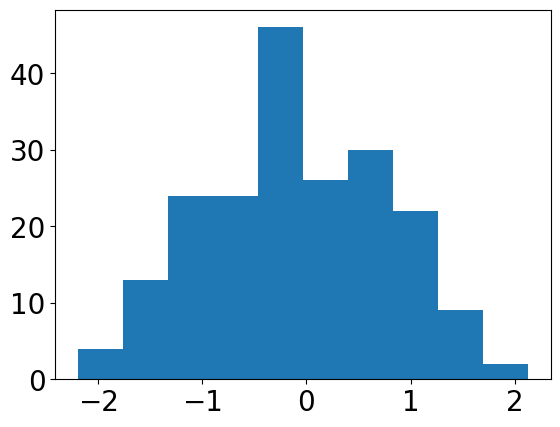

In [181]:
plt.hist(jnp.log(p.eta).flatten())

In [148]:
# for x >= 0: use phi = jnp.exp, psi = jnp.log 
# for x \in [0, 1] use below
def phi(u): 
    return 1 / (1 + jnp.exp(-u))

def psi(x): 
    return jnp.log(x / (1 - x))

In [149]:
key, subkey = jax.random.split(key) 
n_steps, lr = 1000, 1
traj, ents, losses = natural_gradient_dual_space_optimization(subkey, hp, p, n_steps, entropy_loss, lr, phi, psi)

In [153]:
def plot_2d_trajectory(key, hp, W_trajectory, entropies): 
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    axs[0].scatter(W_trajectory[0, 0, :], W_trajectory[0, 1, :], alpha=0.7, label='W_0')
    axs[0].scatter(W_trajectory[-1, 0, :], W_trajectory[-1, 1, :], alpha=0.7, label='W_final') 
    axs[0].set_xlabel(r'$W_{1,j}$')
    axs[0].set_ylabel(r'$W_{2,j}$')
    axs[0].legend()
    axs[0].set_title('W_j')
    key, subkey_cs, subkey_activity_0, subkey_activity_final = jax.random.split(key, 4) 
    cs = draw_cs_sparse_log_normal(subkey_cs, hp) 
    p = Params(W=W_trajectory[0], K=None)
    r_init = compute_receptor_activity(subkey_activity_0, hp, p, cs)
    p = p.replace(W=W_trajectory[-1])
    r_final = compute_receptor_activity(subkey_activity_final, hp, p, cs)
    axs[1].scatter(r_init[0, :], r_init[1, :], alpha=0.7)
    axs[1].scatter(r_final[0, :], r_final[1, :], alpha=0.7)
    axs[2].plot(entropies) 
    return fig, axs

(<Figure size 1800x500 with 3 Axes>,
 array([<Axes: title={'center': 'W_j'}, xlabel='$W_{1,j}$', ylabel='$W_{2,j}$'>,
        <Axes: >, <Axes: >], dtype=object))

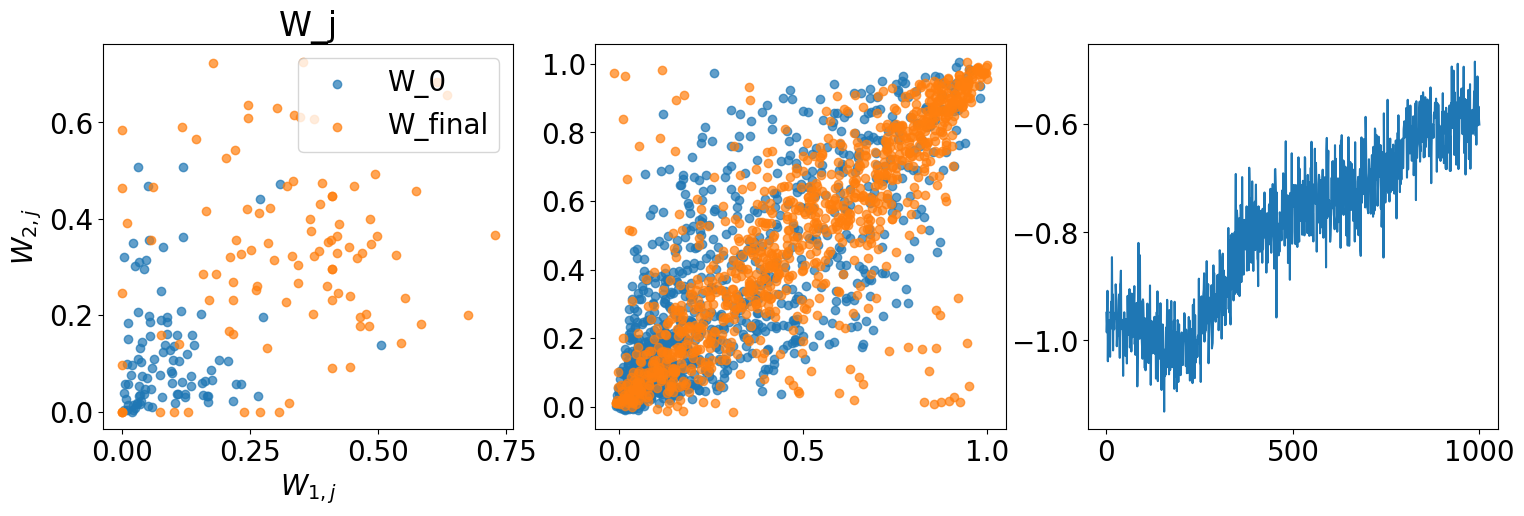

In [154]:
key, subkey = jax.random.split(key) 
plot_2d_trajectory(subkey, hp, traj, ents) 

In [38]:
def sigma_c_to_entropy(key, sigma_c): 
    hp = HyperParams(sigma_c=sigma_c, P=1000) 
    key, *subkeys = jax.random.split(key, 4) 
    hp, p = init(subkeys[0], hp=hp) 
    cs = draw_cs_sparse_log_normal(subkeys[1], hp) 
    r = compute_receptor_activity(subkeys[2], hp, p, cs)
    return compute_entropy(r, hp) 

def probe_entropy_sigma_relationship(key, sigma_cs): 
    fig, ax = plt.subplots()
    ents = []
    key, *subkeys = jax.random.split(key, len(sigma_cs) + 1) 
    for i, sigma_c in enumerate(sigma_cs):
        ents.append(sigma_c_to_entropy(subkeys[i], sigma_c))
    ax.plot(sigma_cs, ents) 
    ax.set_xscale('log')
    ax.set_xlabel('sigma_c') 
    ax.set_ylabel('entropy of r with gamma sensitivities')
    return fig, ax, ents

In [44]:
sigma_cs = np.logspace(-5, 0, 100) 

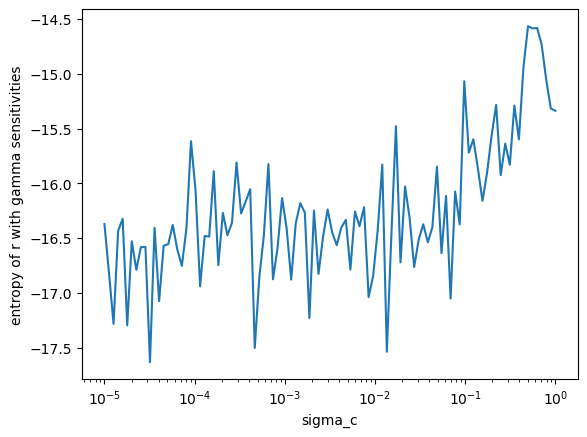

In [45]:
fig, ax, ents = probe_entropy_sigma_relationship(key, sigma_cs) 
fig.savefig('tmp.png') 